# SA-U-Lite Model Testing on CHASE Dataset

This notebook trains and evaluates the SA-U-Lite model (combination of U-Lite + Spatial Attention) on retinal blood vessel segmentation using the CHASE dataset.

In [2]:
# Import required libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tqdm import tqdm
import cv2

# Import the SA-U-Lite model
from models.saulite import SAULite, ConfigurableSAULite

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Libraries imported successfully!
PyTorch version: 2.6.0+cpu
CUDA available: False
Using device: cpu


## Dataset Loading

In [3]:
# CHASE Dataset Class
class CHASEDataset(Dataset):
    """Dataset class for CHASE retinal blood vessel segmentation"""
    
    def __init__(self, image_dir, mask_dir, transform=None, target_size=(256, 256)):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_size = target_size
        
        # Get list of image files
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('.jpg')])
        
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        # Load image
        img_name = self.image_files[idx]
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        
        # Load mask - CHASE uses _1stHO.png suffix
        mask_name = img_name.replace('.jpg', '_1stHO.png')
        mask_path = os.path.join(self.mask_dir, mask_name)
        
        if not os.path.exists(mask_path):
            # Try without _1stHO suffix
            mask_name = img_name.replace('.jpg', '.png')
            mask_path = os.path.join(self.mask_dir, mask_name)
        
        mask = Image.open(mask_path).convert('L')
        
        # Resize
        image = image.resize(self.target_size, Image.BILINEAR)
        mask = mask.resize(self.target_size, Image.NEAREST)
        
        # Convert to numpy
        image = np.array(image, dtype=np.float32) / 255.0
        mask = np.array(mask, dtype=np.float32) / 255.0
        
        # Convert to tensor format (C, H, W)
        image = torch.from_numpy(image.transpose(2, 0, 1))
        mask = torch.from_numpy(mask).unsqueeze(0)
        
        # Binary mask
        mask = (mask > 0.5).float()
        
        return image, mask

# Load datasets
train_dataset = CHASEDataset(
    image_dir='CHASE/train/image',
    mask_dir='CHASE/train/label',
    target_size=(256, 256)
)

val_dataset = CHASEDataset(
    image_dir='CHASE/validate/images',
    mask_dir='CHASE/validate/labels',
    target_size=(256, 256)
)

test_dataset = CHASEDataset(
    image_dir='CHASE/test/image',
    mask_dir='CHASE/test/label',
    target_size=(256, 256)
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 247
Validation samples: 13
Test samples: 8


## Model Setup and Training Functions

In [15]:
# Add this cell after the "Model Setup and Training Functions" markdown and before the training function

# Enhanced Evaluation Metrics
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

def dice_coefficient(pred, target, smooth=1e-6):
    """Calculate Dice coefficient"""
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    return (2. * intersection + smooth) / (pred.sum() + target.sum() + smooth)

def iou_score(pred, target, smooth=1e-6):
    """Calculate IoU (Intersection over Union)"""
    pred = (pred > 0.5).float()
    intersection = (pred * target).sum()
    union = pred.sum() + target.sum() - intersection
    return (intersection + smooth) / (union + smooth)

def sensitivity(pred, target, smooth=1e-6):
    """Calculate Sensitivity (Recall/True Positive Rate)
    SE = TP / (TP + FN)
    """
    pred = (pred > 0.5).float()
    true_positive = (pred * target).sum()
    false_negative = ((1 - pred) * target).sum()
    return (true_positive + smooth) / (true_positive + false_negative + smooth)

def specificity(pred, target, smooth=1e-6):
    """Calculate Specificity (True Negative Rate)
    SP = TN / (TN + FP)
    """
    pred = (pred > 0.5).float()
    true_negative = ((1 - pred) * (1 - target)).sum()
    false_positive = (pred * (1 - target)).sum()
    return (true_negative + smooth) / (true_negative + false_positive + smooth)

def accuracy(pred, target):
    """Calculate Accuracy
    ACC = (TP + TN) / (TP + TN + FP + FN)
    """
    pred = (pred > 0.5).float()
    correct = (pred == target).float().sum()
    total = target.numel()
    return correct / total

def f1_score_manual(pred, target, smooth=1e-6):
    """Calculate F1 Score
    F1 = 2 * (Precision * Recall) / (Precision + Recall)
    """
    pred = (pred > 0.5).float()
    true_positive = (pred * target).sum()
    false_positive = (pred * (1 - target)).sum()
    false_negative = ((1 - pred) * target).sum()
    
    precision = (true_positive + smooth) / (true_positive + false_positive + smooth)
    recall = (true_positive + smooth) / (true_positive + false_negative + smooth)
    
    f1 = 2 * (precision * recall) / (precision + recall + smooth)
    return f1

def calculate_auc(pred_prob, target):
    """Calculate AUC (Area Under ROC Curve)"""
    pred_prob_flat = pred_prob.cpu().numpy().flatten()
    target_flat = target.cpu().numpy().flatten()
    
    try:
        auc = roc_auc_score(target_flat, pred_prob_flat)
        return auc
    except:
        return 0.0

def compute_all_metrics(pred_prob, target):
    """Compute all metrics at once"""
    metrics = {
        'dice': dice_coefficient(pred_prob, target).item(),
        'iou': iou_score(pred_prob, target).item(),
        'sensitivity': sensitivity(pred_prob, target).item(),
        'specificity': specificity(pred_prob, target).item(),
        'accuracy': accuracy(pred_prob, target).item(),
        'f1': f1_score_manual(pred_prob, target).item(),
        'auc': calculate_auc(pred_prob, target)
    }
    return metrics

print("Enhanced metrics defined!")
print("Available metrics: Dice, IoU, Sensitivity, Specificity, Accuracy, F1, AUC")

# Loss function
class DiceBCELoss(nn.Module):
    """Combined Dice + BCE loss"""
    def __init__(self, dice_weight=0.5):
        super(DiceBCELoss, self).__init__()
        self.dice_weight = dice_weight
        self.bce = nn.BCEWithLogitsLoss()
    
    def forward(self, pred, target):
        # BCE Loss
        bce_loss = self.bce(pred, target)
        
        # Dice Loss
        pred_sigmoid = torch.sigmoid(pred)
        intersection = (pred_sigmoid * target).sum()
        dice_loss = 1 - (2. * intersection + 1) / (pred_sigmoid.sum() + target.sum() + 1)
        
        return self.dice_weight * dice_loss + (1 - self.dice_weight) * bce_loss

print("Metrics and loss functions defined!")

Enhanced metrics defined!
Available metrics: Dice, IoU, Sensitivity, Specificity, Accuracy, F1, AUC
Metrics and loss functions defined!


In [16]:
# Training function
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    total_dice = 0
    
    for images, masks in tqdm(train_loader, desc="Training"):
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Metrics
        total_loss += loss.item()
        with torch.no_grad():
            pred_sigmoid = torch.sigmoid(outputs)
            total_dice += dice_coefficient(pred_sigmoid, masks).item()
    
    avg_loss = total_loss / len(train_loader)
    avg_dice = total_dice / len(train_loader)
    
    return avg_loss, avg_dice

# Replace the validate function

def validate(model, val_loader, criterion, device):
    """Validate the model with comprehensive metrics"""
    model.eval()
    total_loss = 0
    metrics_sum = {
        'dice': 0, 'iou': 0, 'sensitivity': 0, 
        'specificity': 0, 'accuracy': 0, 'f1': 0, 'auc': 0
    }
    
    with torch.no_grad():
        for images, masks in tqdm(val_loader, desc="Validation"):
            images, masks = images.to(device), masks.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            
            # Metrics
            pred_sigmoid = torch.sigmoid(outputs)
            batch_metrics = compute_all_metrics(pred_sigmoid, masks)
            
            for key in metrics_sum:
                metrics_sum[key] += batch_metrics[key]
    
    # Average metrics
    num_batches = len(val_loader)
    avg_metrics = {key: val / num_batches for key, val in metrics_sum.items()}
    avg_loss = total_loss / num_batches
    
    return avg_loss, avg_metrics

print("Enhanced validation function defined!")

Enhanced validation function defined!


## Create and Train SA-U-Lite Model

In [18]:
# Create SA-U-Lite model
model = ConfigurableSAULite(
    input_channel=3,
    num_classes=1,
    base_channels=16,
    activation='gelu',
    dropout_rate=0.1,
    attention_kernel_size=7
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"SA-U-Lite Model Created!")
print(f"Total trainable parameters: {total_params:,}")

# Setup training
criterion = DiceBCELoss(dice_weight=0.5)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5, verbose=True)

num_epochs = 5
best_dice = 0.0

# Training history
history = {
    'train_loss': [],
    'train_dice': [],
    'val_loss': [],
    'val_dice': [],
    'val_iou': []
}

print(f"\nTraining Configuration:")
print(f"  Epochs: {num_epochs}")
print(f"  Optimizer: Adam (lr=0.001)")
print(f"  Loss: Dice + BCE")
print(f"  Device: {device}")
print(f"\nStarting training...")

SA-U-Lite Model Created!
Total trainable parameters: 878,515

Training Configuration:
  Epochs: 5
  Optimizer: Adam (lr=0.001)
  Loss: Dice + BCE
  Device: cpu

Starting training...


In [19]:
# Replace the training loop cell

# Training loop with enhanced metrics
for epoch in range(num_epochs):
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    
    # Train
    train_loss, train_dice = train_epoch(model, train_loader, criterion, optimizer, device)
    
    # Validate
    val_loss, val_metrics = validate(model, val_loader, criterion, device)
    
    # Learning rate scheduling
    scheduler.step(val_metrics['dice'])
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_metrics['dice'])
    history['val_iou'].append(val_metrics['iou'])
    
    # Print metrics
    print(f"  Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}")
    print(f"  Val Loss: {val_loss:.4f}")
    print(f"  Val Dice: {val_metrics['dice']:.4f}, IoU: {val_metrics['iou']:.4f}")
    print(f"  Val SE: {val_metrics['sensitivity']:.4f}, SP: {val_metrics['specificity']:.4f}")
    print(f"  Val ACC: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1']:.4f}, AUC: {val_metrics['auc']:.4f}")
    
    # Save best model
    if val_metrics['dice'] > best_dice:
        best_dice = val_metrics['dice']
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_metrics': val_metrics,
        }, 'best_saulite_model.pth')
        print(f"  ✓ Best model saved! (Dice: {best_dice:.4f})")

print("\n" + "="*60)
print("Training completed!")
print(f"Best validation Dice: {best_dice:.4f}")
print("="*60)


Epoch [1/5]


Validation: 100%|██████████| 4/4 [00:02<00:00,  1.66it/s]



  Train Loss: 0.7224, Train Dice: 0.3671
  Val Loss: 0.6336
  Val Dice: 0.5394, IoU: 0.3694
  Val SE: 0.4885, SP: 0.9726
  Val ACC: 0.9349, F1: 0.5394, AUC: 0.8666
  ✓ Best model saved! (Dice: 0.5394)

Epoch [2/5]


Validation: 100%|██████████| 4/4 [00:02<00:00,  1.62it/s]



  Train Loss: 0.5310, Train Dice: 0.5907
  Val Loss: 0.3962
  Val Dice: 0.5910, IoU: 0.4197
  Val SE: 0.4814, SP: 0.9875
  Val ACC: 0.9481, F1: 0.5910, AUC: 0.9064
  ✓ Best model saved! (Dice: 0.5910)

Epoch [3/5]


Validation: 100%|██████████| 4/4 [00:02<00:00,  1.47it/s]



  Train Loss: 0.3421, Train Dice: 0.6552
  Val Loss: 0.2761
  Val Dice: 0.6661, IoU: 0.4996
  Val SE: 0.5631, SP: 0.9892
  Val ACC: 0.9560, F1: 0.6661, AUC: 0.9453
  ✓ Best model saved! (Dice: 0.6661)

Epoch [4/5]


Validation: 100%|██████████| 4/4 [00:02<00:00,  1.55it/s]



  Train Loss: 0.2903, Train Dice: 0.6948
  Val Loss: 0.2264
  Val Dice: 0.7243, IoU: 0.5684
  Val SE: 0.6891, SP: 0.9820
  Val ACC: 0.9592, F1: 0.7243, AUC: 0.9583
  ✓ Best model saved! (Dice: 0.7243)

Epoch [5/5]


Validation: 100%|██████████| 4/4 [00:02<00:00,  1.51it/s]



  Train Loss: 0.2708, Train Dice: 0.7169
  Val Loss: 0.2177
  Val Dice: 0.7383, IoU: 0.5857
  Val SE: 0.7613, SP: 0.9747
  Val ACC: 0.9581, F1: 0.7383, AUC: 0.9645
  ✓ Best model saved! (Dice: 0.7383)

Training completed!
Best validation Dice: 0.7383


## Visualize Training History

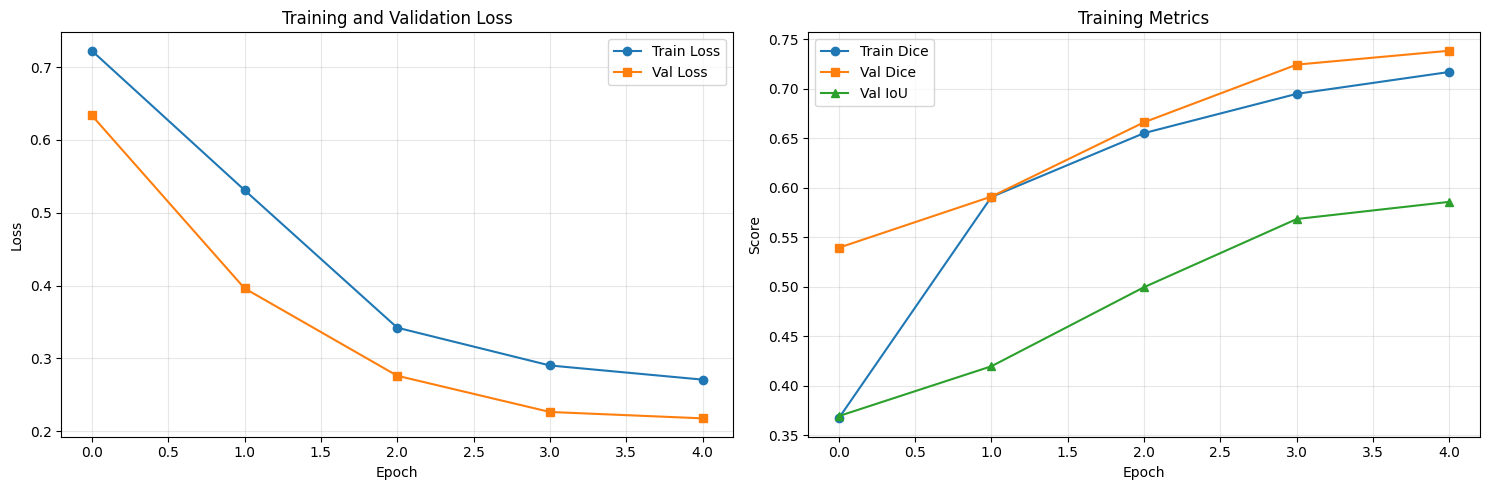

Final Results:
  Best Validation Dice: 0.7383
  Best Validation IoU: 0.5857


In [20]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Dice and IoU curves
axes[1].plot(history['train_dice'], label='Train Dice', marker='o')
axes[1].plot(history['val_dice'], label='Val Dice', marker='s')
axes[1].plot(history['val_iou'], label='Val IoU', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Training Metrics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Final Results:")
print(f"  Best Validation Dice: {max(history['val_dice']):.4f}")
print(f"  Best Validation IoU: {max(history['val_iou']):.4f}")

## Test Set Evaluation

In [21]:
# Replace the test evaluation cell

# Load best model
checkpoint = torch.load('best_saulite_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Validation metrics:")
for key, val in checkpoint['val_metrics'].items():
    print(f"  {key.upper()}: {val:.4f}")

# Evaluate on test set with all metrics
model.eval()
test_metrics = {
    'dice': [], 'iou': [], 'sensitivity': [], 'specificity': [],
    'accuracy': [], 'f1': [], 'auc': []
}

with torch.no_grad():
    for images, masks in tqdm(test_loader, desc="Testing"):
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        outputs = model(images)
        pred_sigmoid = torch.sigmoid(outputs)
        
        # Calculate all metrics
        batch_metrics = compute_all_metrics(pred_sigmoid, masks)
        
        for key in test_metrics:
            test_metrics[key].append(batch_metrics[key])

# Calculate statistics
print("\n" + "="*80)
print("TEST SET RESULTS - COMPREHENSIVE EVALUATION")
print("="*80)
print(f"\n{'Metric':<15} {'Mean':<12} {'Std':<12} {'Min':<12} {'Max':<12}")
print("-" * 80)
for metric_name, values in test_metrics.items():
    mean_val = np.mean(values)
    std_val = np.std(values)
    min_val = np.min(values)
    max_val = np.max(values)
    print(f"{metric_name.upper():<15} {mean_val:<12.4f} {std_val:<12.4f} {min_val:<12.4f} {max_val:<12.4f}")
print("="*80)

# Store for later use
test_dice_scores = test_metrics['dice']
test_iou_scores = test_metrics['iou']

Loaded best model from epoch 5
Validation metrics:
  DICE: 0.7383
  IOU: 0.5857
  SENSITIVITY: 0.7613
  SPECIFICITY: 0.9747
  ACCURACY: 0.9581
  F1: 0.7383
  AUC: 0.9645


Testing: 100%|██████████| 8/8 [00:01<00:00,  4.41it/s]


TEST SET RESULTS - COMPREHENSIVE EVALUATION

Metric          Mean         Std          Min          Max         
--------------------------------------------------------------------------------
DICE            0.7050       0.0250       0.6651       0.7380      
IOU             0.5450       0.0297       0.4983       0.5848      
SENSITIVITY     0.7913       0.0360       0.7399       0.8596      
SPECIFICITY     0.9696       0.0044       0.9632       0.9781      
ACCURACY        0.9583       0.0059       0.9528       0.9691      
F1              0.7050       0.0250       0.6651       0.7380      
AUC             0.9669       0.0073       0.9562       0.9801      


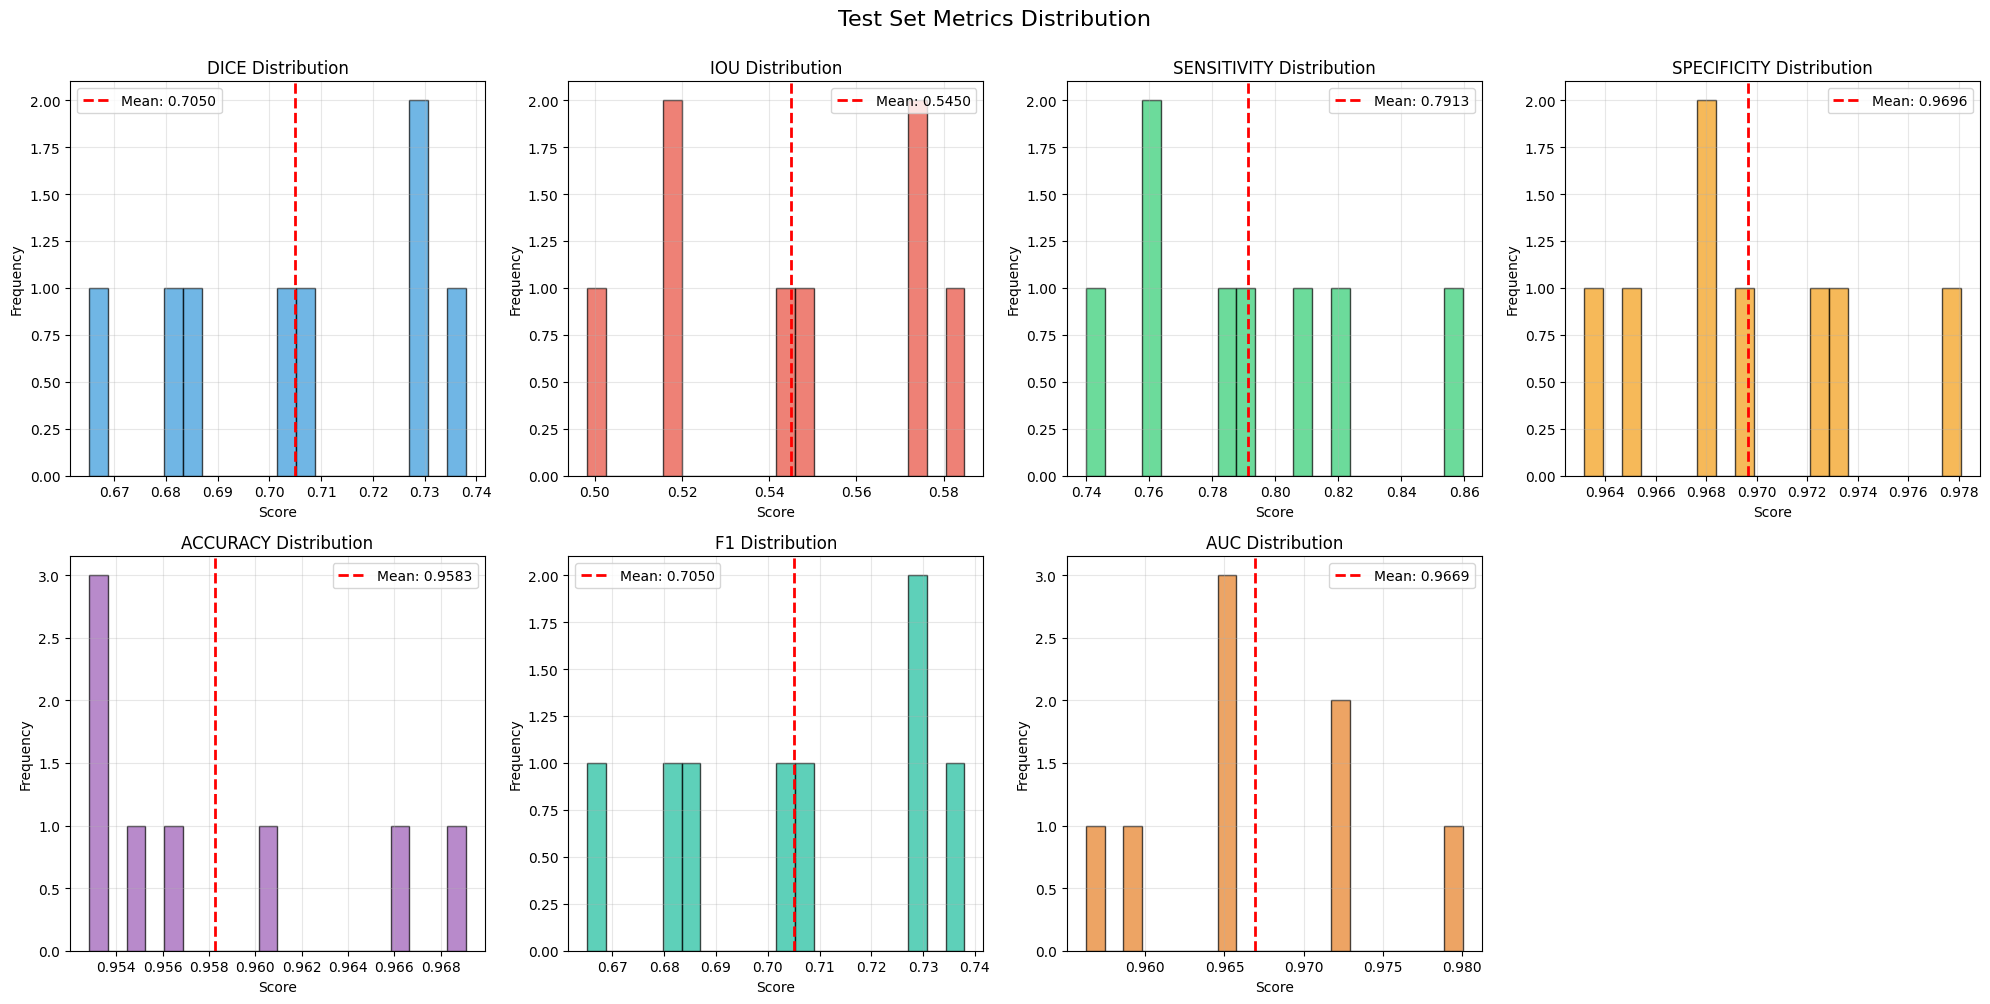

In [22]:
# Add this as a new cell after test evaluation

# Visualize test metrics distribution
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Test Set Metrics Distribution', fontsize=16, y=1.00)

metrics_list = ['dice', 'iou', 'sensitivity', 'specificity', 'accuracy', 'f1', 'auc']
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c', '#e67e22']

for idx, (metric_name, color) in enumerate(zip(metrics_list, colors)):
    row = idx // 4
    col = idx % 4
    
    values = test_metrics[metric_name]
    
    # Histogram
    axes[row, col].hist(values, bins=20, alpha=0.7, color=color, edgecolor='black')
    axes[row, col].axvline(np.mean(values), color='red', linestyle='--', 
                           linewidth=2, label=f'Mean: {np.mean(values):.4f}')
    axes[row, col].set_xlabel('Score')
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].set_title(f'{metric_name.upper()} Distribution')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

# Remove empty subplot
axes[1, 3].axis('off')

plt.tight_layout()
plt.show()

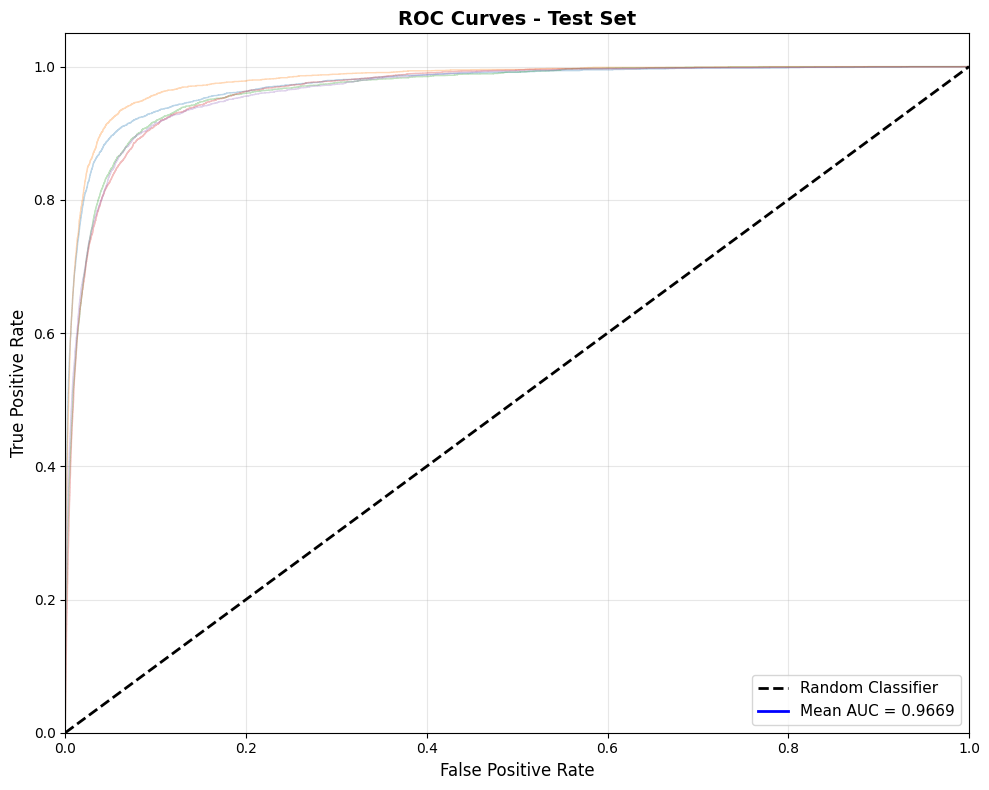

Mean AUC Score: 0.9669 ± 0.0073


In [23]:
# Add this as a new cell for ROC curve

# Plot ROC Curves for test samples
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

model.eval()
all_fpr = []
all_tpr = []
all_auc = []

with torch.no_grad():
    for idx, (images, masks) in enumerate(test_loader):
        images, masks = images.to(device), masks.to(device)
        
        # Forward pass
        outputs = model(images)
        pred_sigmoid = torch.sigmoid(outputs)
        
        # Get predictions and targets
        pred_flat = pred_sigmoid.cpu().numpy().flatten()
        target_flat = masks.cpu().numpy().flatten()
        
        # Calculate ROC curve
        try:
            fpr, tpr, _ = roc_curve(target_flat, pred_flat)
            auc_score = roc_auc_score(target_flat, pred_flat)
            
            all_fpr.append(fpr)
            all_tpr.append(tpr)
            all_auc.append(auc_score)
            
            # Plot individual curves (light)
            if idx < 5:  # Plot first 5 for clarity
                ax.plot(fpr, tpr, alpha=0.3, linewidth=1)
        except:
            continue

# Plot mean ROC curve
mean_auc = np.mean(all_auc)
ax.plot([0, 1], [0, 1], 'k--', linewidth=2, label='Random Classifier')
ax.plot([], [], 'b-', linewidth=2, label=f'Mean AUC = {mean_auc:.4f}')

ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.set_title('ROC Curves - Test Set', fontsize=14, fontweight='bold')
ax.legend(loc='lower right', fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])

plt.tight_layout()
plt.show()

print(f"Mean AUC Score: {mean_auc:.4f} ± {np.std(all_auc):.4f}")

## Visualize Segmentation Results

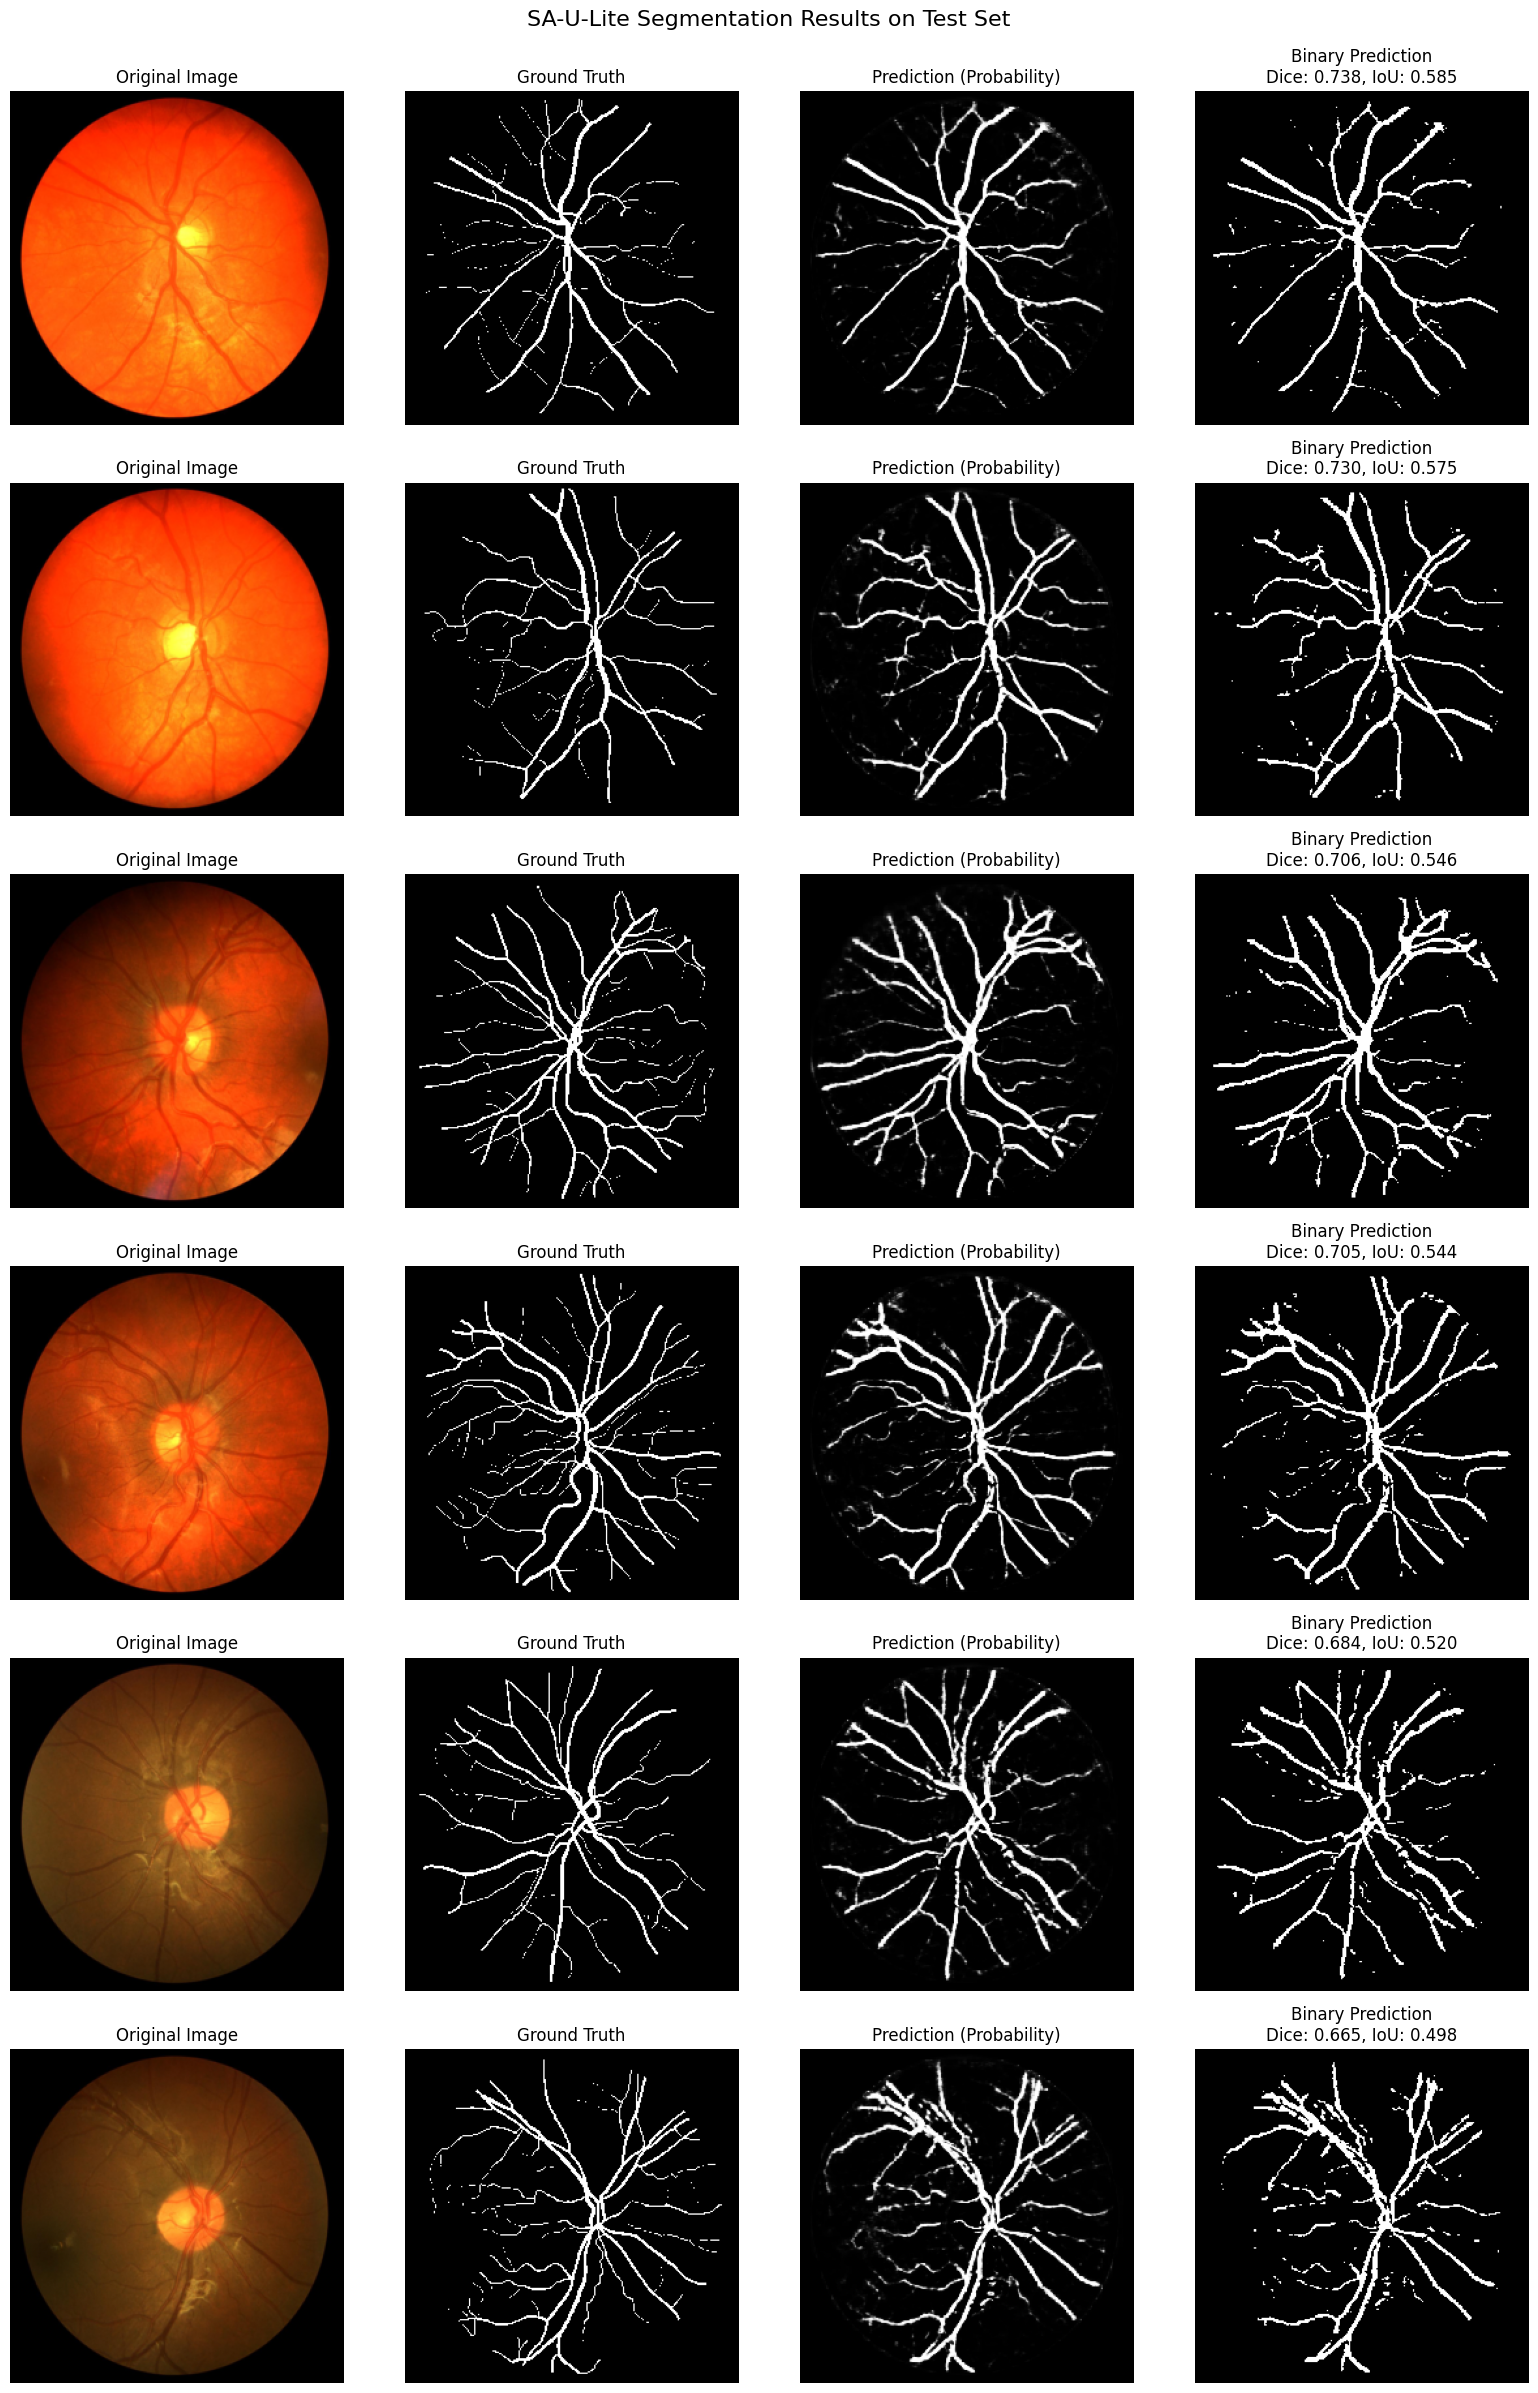

In [24]:
# Visualize predictions on test set
num_samples = 6
model.eval()

fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
fig.suptitle('SA-U-Lite Segmentation Results on Test Set', fontsize=16, y=0.995)

with torch.no_grad():
    for idx in range(num_samples):
        # Get sample
        image, mask = test_dataset[idx]
        image_batch = image.unsqueeze(0).to(device)
        
        # Predict
        output = model(image_batch)
        pred = torch.sigmoid(output).squeeze().cpu().numpy()
        pred_binary = (pred > 0.5).astype(np.float32)
        
        # Convert for visualization
        img_display = image.permute(1, 2, 0).cpu().numpy()
        mask_display = mask.squeeze().cpu().numpy()
        
        # Calculate metrics for this sample
        dice = dice_coefficient(torch.from_numpy(pred_binary).unsqueeze(0).unsqueeze(0), 
                                mask.unsqueeze(0)).item()
        iou = iou_score(torch.from_numpy(pred_binary).unsqueeze(0).unsqueeze(0), 
                       mask.unsqueeze(0)).item()
        
        # Plot
        axes[idx, 0].imshow(img_display)
        axes[idx, 0].set_title('Original Image')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(mask_display, cmap='gray')
        axes[idx, 1].set_title('Ground Truth')
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(pred, cmap='gray', vmin=0, vmax=1)
        axes[idx, 2].set_title('Prediction (Probability)')
        axes[idx, 2].axis('off')
        
        axes[idx, 3].imshow(pred_binary, cmap='gray')
        axes[idx, 3].set_title(f'Binary Prediction\nDice: {dice:.3f}, IoU: {iou:.3f}')
        axes[idx, 3].axis('off')

plt.tight_layout()
plt.show()

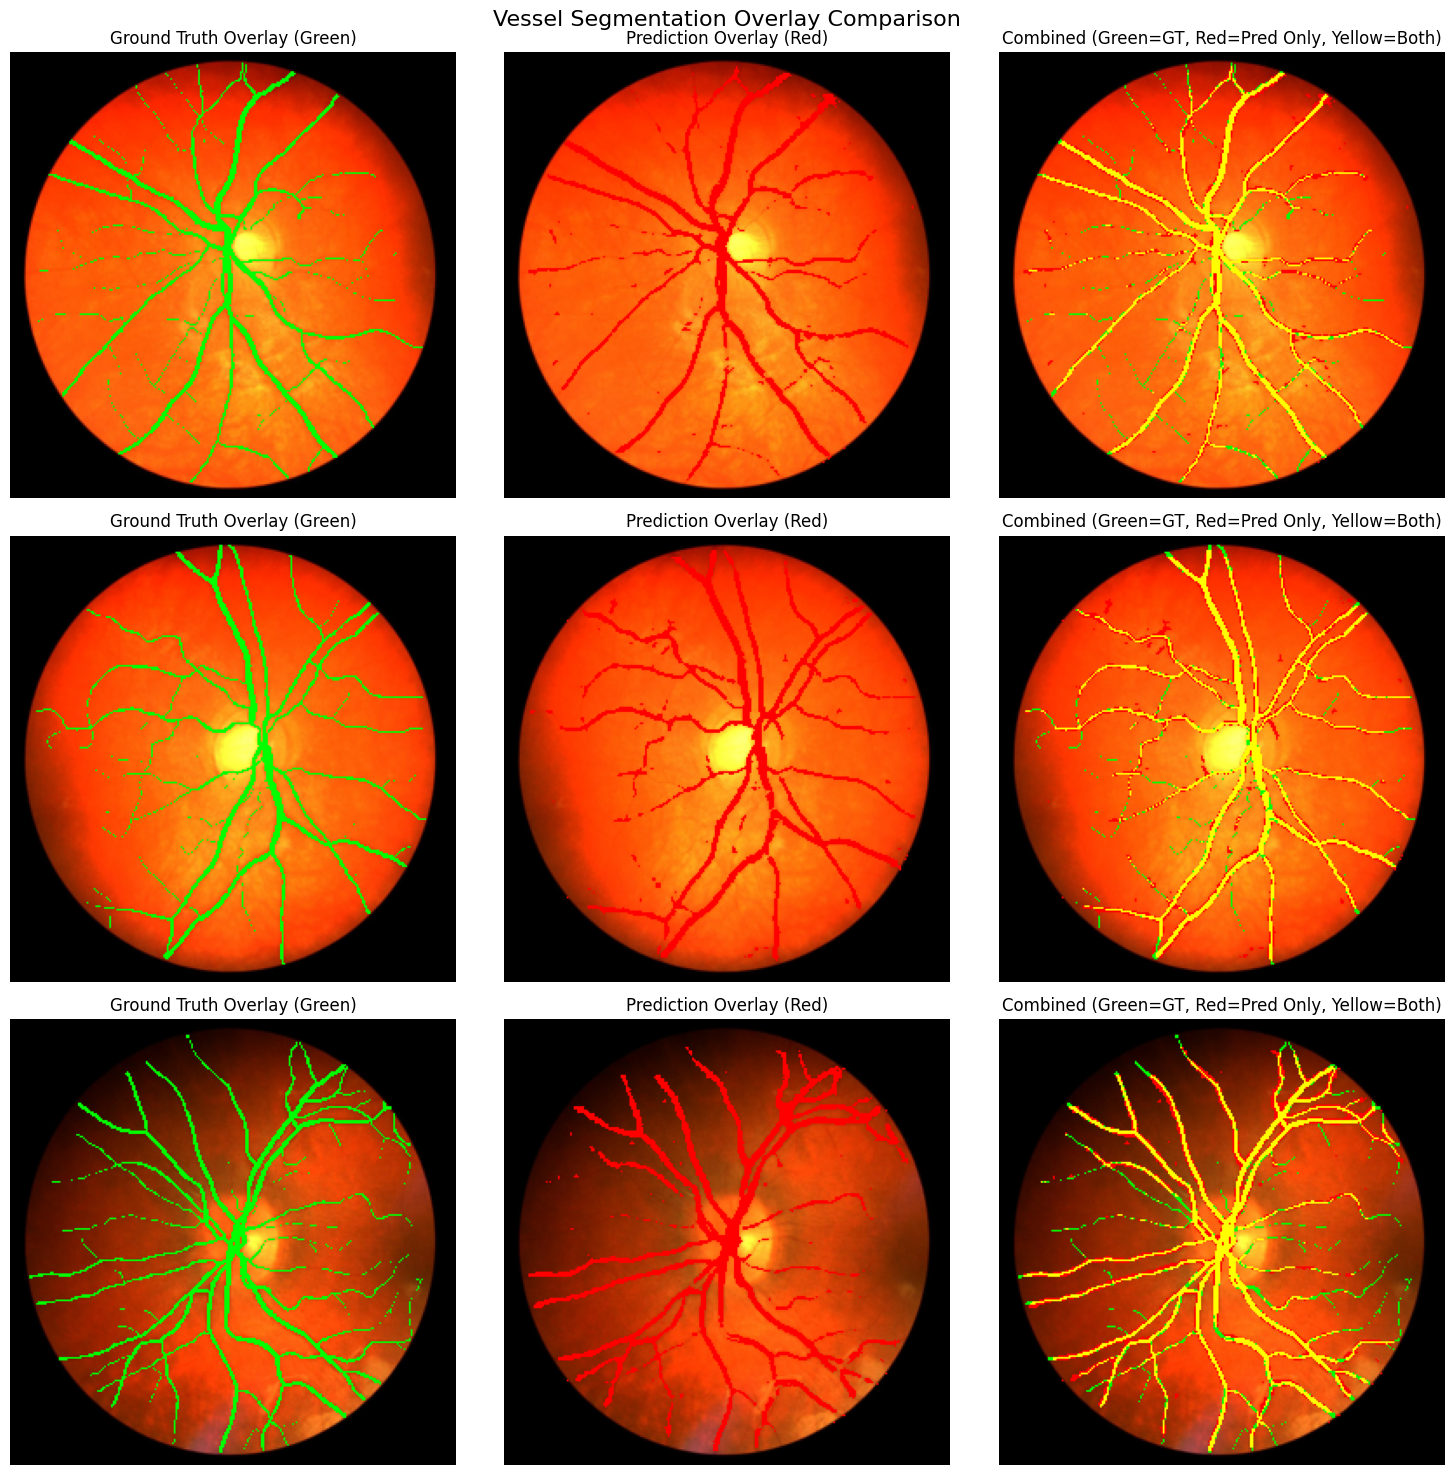

In [25]:
# Create overlay visualizations
num_samples = 3
fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5*num_samples))
fig.suptitle('Vessel Segmentation Overlay Comparison', fontsize=16)

with torch.no_grad():
    for idx in range(num_samples):
        # Get sample
        image, mask = test_dataset[idx]
        image_batch = image.unsqueeze(0).to(device)
        
        # Predict
        output = model(image_batch)
        pred = torch.sigmoid(output).squeeze().cpu().numpy()
        pred_binary = (pred > 0.5).astype(np.uint8)
        
        # Convert for visualization
        img_display = (image.permute(1, 2, 0).cpu().numpy() * 255).astype(np.uint8)
        mask_display = (mask.squeeze().cpu().numpy() * 255).astype(np.uint8)
        
        # Create overlays
        gt_overlay = img_display.copy()
        gt_overlay[mask_display > 128] = [0, 255, 0]  # Green for ground truth
        
        pred_overlay = img_display.copy()
        pred_overlay[pred_binary > 0] = [255, 0, 0]  # Red for prediction
        
        combined_overlay = img_display.copy()
        combined_overlay[mask_display > 128] = [0, 255, 0]  # Green for GT
        combined_overlay[pred_binary > 0] = [255, 255, 0]  # Yellow for both
        combined_overlay[(mask_display > 128) & (pred_binary == 0)] = [0, 255, 0]  # Green for GT only
        combined_overlay[(mask_display <= 128) & (pred_binary > 0)] = [255, 0, 0]  # Red for Pred only
        
        # Plot
        axes[idx, 0].imshow(gt_overlay)
        axes[idx, 0].set_title('Ground Truth Overlay (Green)')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(pred_overlay)
        axes[idx, 1].set_title('Prediction Overlay (Red)')
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(combined_overlay)
        axes[idx, 2].set_title('Combined (Green=GT, Red=Pred Only, Yellow=Both)')
        axes[idx, 2].axis('off')

plt.tight_layout()
plt.show()

## Save Segmentation Results

In [ ]:
# Save predictions for all test images
output_dir = 'segmentation_results'
os.makedirs(output_dir, exist_ok=True)

model.eval()
with torch.no_grad():
    for idx in range(len(test_dataset)):
        # Get sample
        image, mask = test_dataset[idx]
        image_batch = image.unsqueeze(0).to(device)
        
        # Predict
        output = model(image_batch)
        pred = torch.sigmoid(output).squeeze().cpu().numpy()
        pred_binary = (pred > 0.5).astype(np.uint8) * 255
        
        # Save prediction
        pred_img = Image.fromarray(pred_binary)
        pred_img.save(os.path.join(output_dir, f'prediction_{idx:03d}.png'))
        
        # Save probability map
        prob_map = (pred * 255).astype(np.uint8)
        prob_img = Image.fromarray(prob_map)
        prob_img.save(os.path.join(output_dir, f'probability_{idx:03d}.png'))

print(f"✓ Saved {len(test_dataset)} segmentation results to '{output_dir}/'")
print(f"  - Binary predictions: prediction_XXX.png")
print(f"  - Probability maps: probability_XXX.png")

## Summary and Model Information

In [14]:
# Final Summary
print("="*80)
print("SA-U-LITE MODEL EVALUATION SUMMARY")
print("="*80)
print("\n📊 Model Architecture:")
print(f"  - Name: SA-U-Lite (Spatial Attention U-Lite)")
print(f"  - Base Channels: 16")
print(f"  - Activation: GELU")
print(f"  - Attention Kernel Size: 7")
print(f"  - Dropout Rate: 0.1")
print(f"  - Total Parameters: {total_params:,}")

print("\n📈 Training Configuration:")
print(f"  - Dataset: CHASE")
print(f"  - Training Samples: {len(train_dataset)}")
print(f"  - Validation Samples: {len(val_dataset)}")
print(f"  - Test Samples: {len(test_dataset)}")
print(f"  - Epochs: {num_epochs}")
print(f"  - Batch Size: 4")
print(f"  - Optimizer: Adam (lr=0.001)")
print(f"  - Loss Function: Dice + BCE")

print("\n🎯 Performance Metrics:")
print(f"  - Best Validation Dice: {best_dice:.4f}")
print(f"  - Test Dice Score: {np.mean(test_dice_scores):.4f} ± {np.std(test_dice_scores):.4f}")
print(f"  - Test IoU Score: {np.mean(test_iou_scores):.4f} ± {np.std(test_iou_scores):.4f}")

print("\n💾 Saved Files:")
print(f"  - Best Model: best_saulite_model.pth")
print(f"  - Segmentation Results: {output_dir}/")

print("\n✨ Key Features of SA-U-Lite:")
print("  ✓ Lightweight architecture using axial depthwise convolutions")
print("  ✓ Spatial attention mechanism in bottleneck for better feature focus")
print("  ✓ Efficient parameter usage while maintaining performance")
print("  ✓ Combines benefits of U-Lite and SA-UNet")

print("\n" + "="*80)

SA-U-LITE MODEL EVALUATION SUMMARY

📊 Model Architecture:
  - Name: SA-U-Lite (Spatial Attention U-Lite)
  - Base Channels: 16
  - Activation: GELU
  - Attention Kernel Size: 7
  - Dropout Rate: 0.1
  - Total Parameters: 878,515

📈 Training Configuration:
  - Dataset: CHASE
  - Training Samples: 247
  - Validation Samples: 13
  - Test Samples: 8
  - Epochs: 30
  - Batch Size: 4
  - Optimizer: Adam (lr=0.001)
  - Loss Function: Dice + BCE

🎯 Performance Metrics:
  - Best Validation Dice: 0.7727
  - Test Dice Score: 0.7315 ± 0.0265
  - Test IoU Score: 0.5774 ± 0.0326

💾 Saved Files:
  - Best Model: best_saulite_model.pth


NameError: name 'output_dir' is not defined